In [41]:
import pandas as pd
import numpy as np

import scipy as sp
import sklearn as sk
from scipy import stats
from scipy.stats import norm

import random
import time

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output


In [6]:
#common model algorithms
from sklearn import svm, tree, gaussian_process, linear_model, ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#common model help tools
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('darkgrid')
pylab.rcParams['figure.figsize'] = 16,8

In [7]:
#import data
PATH1 = "C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Source Data files/"   #where you read the files from
PATH2 = "C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Submissions/"   #where you export the files to
train_data = pd.read_csv(f'{PATH1}cleaned_train_data.csv')
test_data = pd.read_csv(f'{PATH1}cleaned_test_data.csv')

#make copy of training data to play with
play_data = train_data.copy()
#pass both data sets to clean everything at once
scaling_data = [play_data, test_data]

#print(test_data.info())

#train_data.sample(5)

Exploratory Analysis
--

Exploring "LotArea"
--

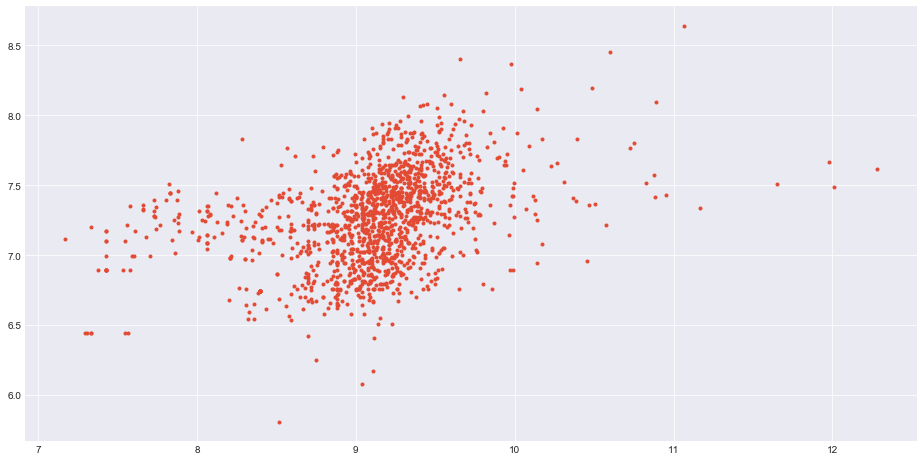

In [9]:

plt.plot(np.log(play_data.LotArea), np.log(play_data.GrLivArea),
        '.', alpha = 1)

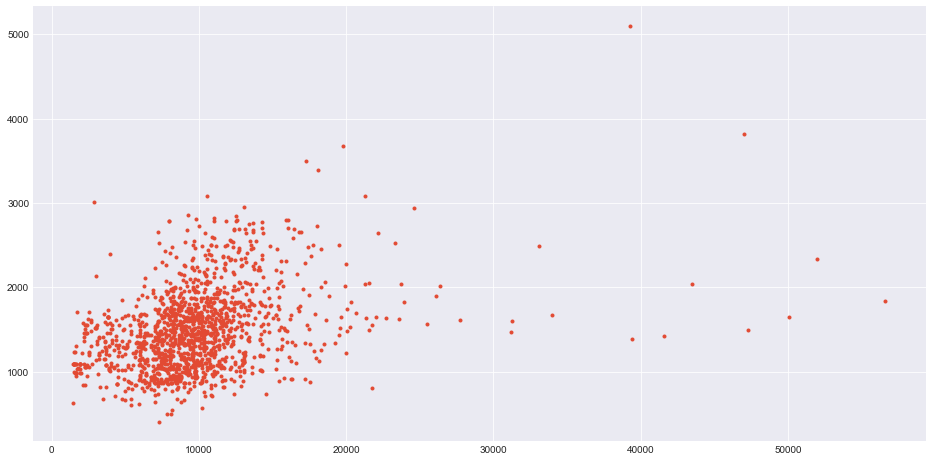

In [59]:
plt.plot(test_data['LotArea'], test_data['GrLivArea'],
        '.', alpha = 1)

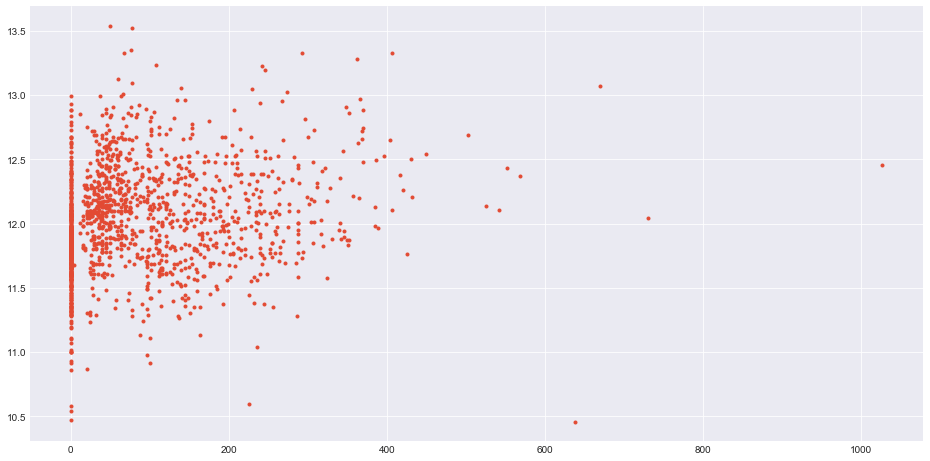

In [10]:
plt.plot(play_data.TotalPorchSF, np.log(play_data.SalePrice),
        '.', alpha = 1)

In [77]:
cond = (play_data.LotArea < 70000)
df = play_data.loc[cond]
#df[['LotArea','GrLivArea','SalePrice']].sort_values(['LotArea'], ascending=False)
df['SalePriceBin'] = pd.qcut(df['SalePrice'],12)
df['SalePriceBin'].sort_values()


df3 = df.loc[(df['SalePrice'] > 200000),['Id', 'GrLivArea', 'LotArea', 'SalePrice']]
df3['SalePriceBin'] = pd.qcut(df3['SalePrice'],12)
df3['GrLivAreaBin'] = pd.qcut(df3['GrLivArea'],10)
#df3.groupby('SalePriceBin')['LotArea'].max().sort_values()
df3.groupby('GrLivAreaBin')['LotArea'].max().sort_values()

GrLivAreaBin
(1685.8, 1786.2]      16669
(2127.0, 2341.6]      21000
(1500.3, 1607.6]      23595
(2005.6, 2127.0]      27650
(1207.999, 1500.3]    39104
(2341.6, 2628.2]      46589
(1786.2, 1908.0]      50271
(1908.0, 2005.6]      53107
(1607.6, 1685.8]      53227
(2628.2, 5642.0]      63887
Name: LotArea, dtype: int64

In [101]:
#play_arena
ndf = play_data.loc[(play_data.LotArea > 100000)]
ndf[['Id','LotArea','GrLivArea','SalePrice']].sort_values(['LotArea'], ascending=False)

,Id,LotArea,GrLivArea,SalePrice



 mu = 12.03 and sigma = 0.40



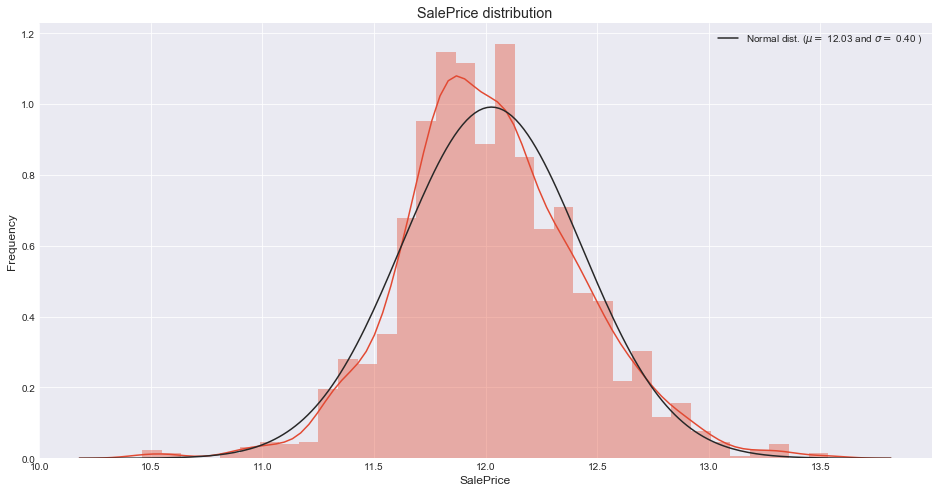

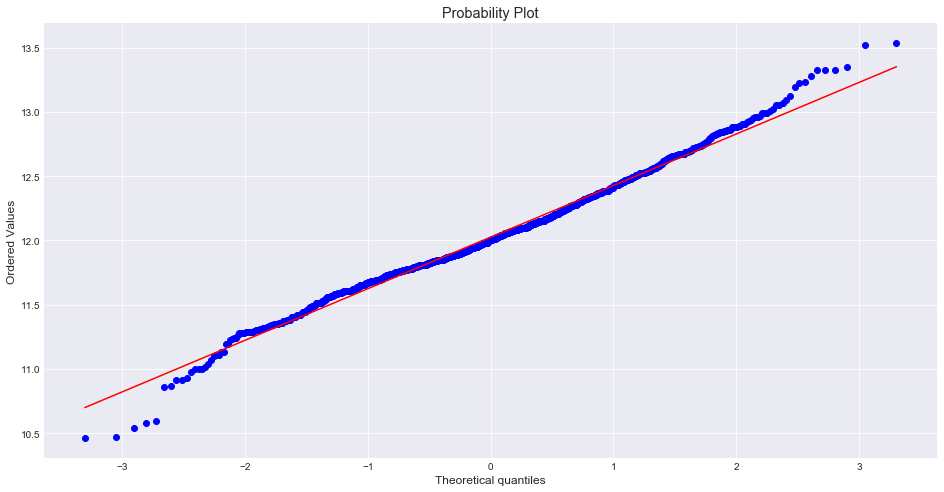

In [43]:
sns.distplot(np.log(play_data['SalePrice']), fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log(play_data['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log(play_data['SalePrice']), plot=plt)
plt.show()

In [51]:
play_data_na = (play_data.isnull().sum() / len(play_data)) * 100
play_data_na = play_data_na.drop(play_data_na[play_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :play_data_na})
missing_data.head(20)

,Missing Ratio


ValueError: could not broadcast input array from shape (1460,77) into shape (1460)

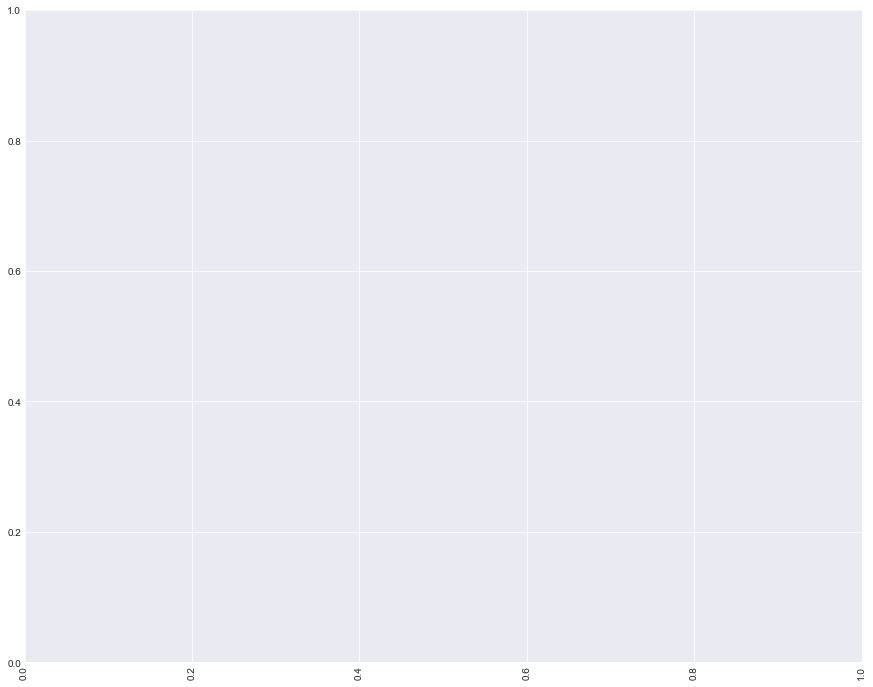

In [48]:
#Plot missing values
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=play_data.index, y=play_data)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Exploring outliers for "GrLivArea"
--

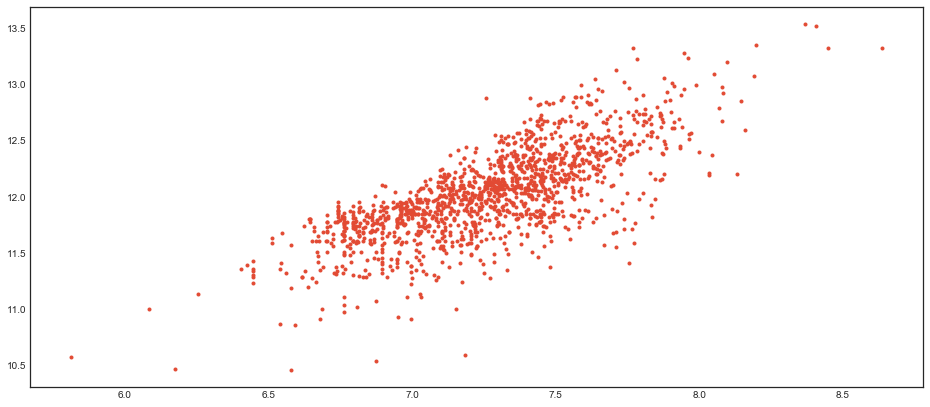

In [17]:
plt.figure(figsize=[16,7])
plt.plot(np.log(play_data.GrLivArea), np.log(play_data.SalePrice),
         '.', alpha = 1)
 
#plt.plot(play_data.GrLivArea, np.log(play_data.SalePrice),
 #       '.', alpha = 1)

In [ ]:
#play_data.drop(play_data[play_data.Id == 524].index, inplace=True)  #outliers for GrLivArea
cond2 = ((play_data.Id == 524) | (play_data.Id == 1299))
play_data.loc[cond2,'SalePrice'] = 611657
#play_data.drop(play_data[play_data.Id == 1299].index, inplace=True)  #outliers for GrLivArea

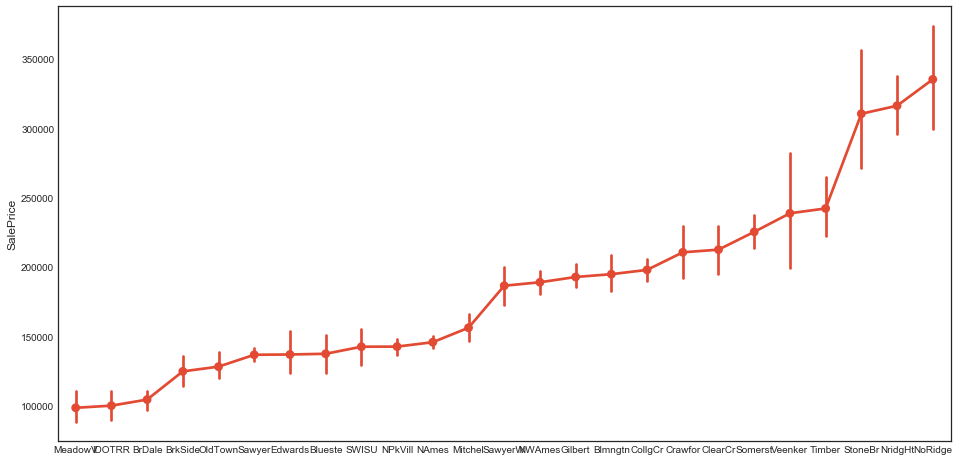

In [10]:
#df.Neighborhood.value_counts()
Neighborhood_meanSalePrice = play_data.groupby('Neighborhood')['SalePrice'].mean().sort_values()
sns.pointplot(x = play_data.Neighborhood.values, y = play_data.SalePrice, 
             order = Neighborhood_meanSalePrice.index)

Exploring outliers for "YearBuilt"
--

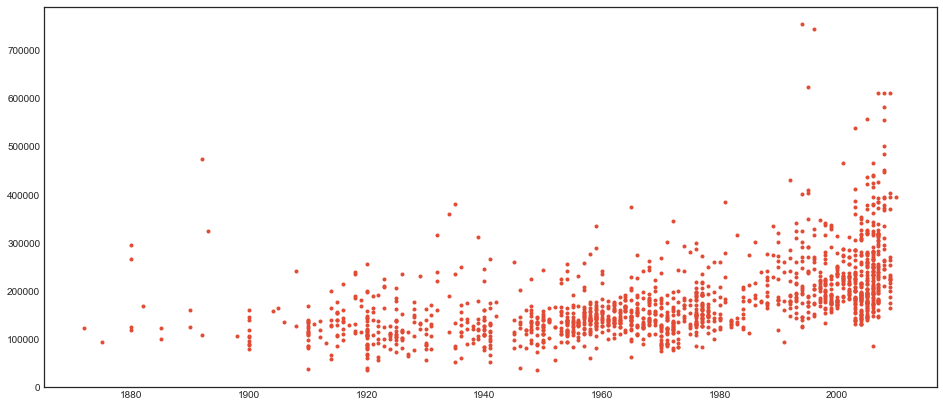

In [105]:
plt.figure(figsize=[16,7])
plt.plot(play_data.YearBuilt, play_data.SalePrice,
         '.', alpha = 1) 

In [152]:

df3 = play_data.loc[ ((play_data['SalePrice']<700000) & (play_data['GrLivArea'] > 3000)),['Id','YearBuilt','LotArea','GrLivArea','SalePrice']]
#df3 = play_data.loc[ ((play_data['SalePrice']<700000) & (play_data['LotArea'] > 15000)),['Id','YearBuilt','LotArea','GrLivArea','SalePrice']]
#df3 = play_data.loc[(play_data['YearBuilt'] > 1990),['Id','YearBuilt','LotArea','GrLivArea','SalePrice']]
df3.groupby('YearBuilt')['SalePrice'].max()

df3['LotAreaBin'] = pd.qcut(df3['LotArea'],10)
df3['GrLivAreaBin'] = pd.qcut(df3['GrLivArea'],10)
#df3.groupby('LotAreaBin')['SalePrice'].max()
df3.groupby('GrLivAreaBin')['SalePrice'].mean()

GrLivAreaBin
(3081.999, 3099.0]    198750
(3099.0, 3140.0]      360000
(3140.0, 3208.0]      359100
(3208.0, 3228.0]      375000
(3228.0, 3258.5]      410000
(3258.5, 3395.0]      369000
(3395.0, 3470.0]      381000
(3470.0, 3608.0]      385000
(3608.0, 4151.5]      625000
(4151.5, 5642.0]      611657
Name: SalePrice, dtype: int64

In [132]:
df4 = play_data.loc[(play_data['SalePrice']>700000),['Id','YearBuilt','LotArea','GrLivArea','SalePrice']]
df4

,Id,YearBuilt,LotArea,GrLivArea,SalePrice
691,692,1994,21535,4316,755000
1182,1183,1996,15623,4476,745000


(array([  2.,  53.,   0., 384.,   0., 792., 187.,   0.,  27.,  14.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

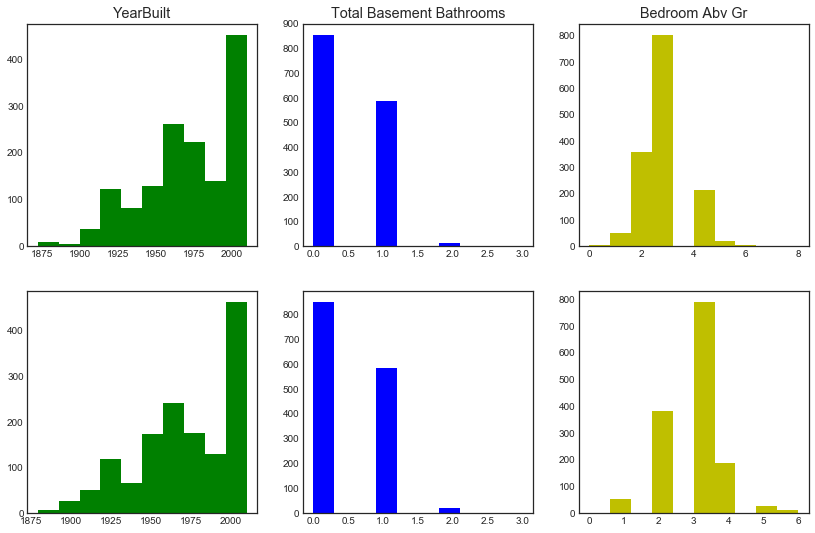

In [106]:
#plot Outliers
plt.figure(figsize=[14,9])

plt.subplot(231)
plt.hist(x = play_data['YearBuilt'], color='g')
plt.title('YearBuilt')

plt.subplot(232)
plt.hist(x = play_data['BsmtFullBath'], color='b')
plt.title('Total Basement Bathrooms')

plt.subplot(233)
plt.hist(x = play_data['BedroomAbvGr'], color='y')
plt.title('Bedroom Abv Gr')

plt.subplot(234)
plt.hist(x = test_data['YearBuilt'], color='g')
#plt.title('Full Bath')

plt.subplot(235)
plt.hist(x = test_data['BsmtFullBath'], color='b')
#plt.title('Half Bath')

plt.subplot(236)
plt.hist(x = test_data['BedroomAbvGr'], color='y')
#plt.title('Bedroom')

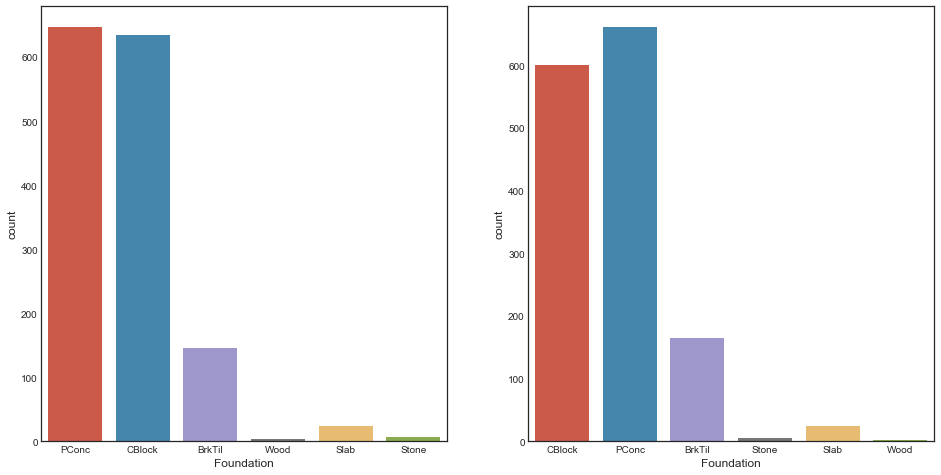

In [107]:
play_data.Foundation.value_counts()
plt.subplot(121)
sns.countplot(play_data.Foundation)

plt.subplot(122)
test_data.Foundation.value_counts()
sns.countplot(test_data.Foundation)

In [11]:
play_data.shape

(1460, 79)

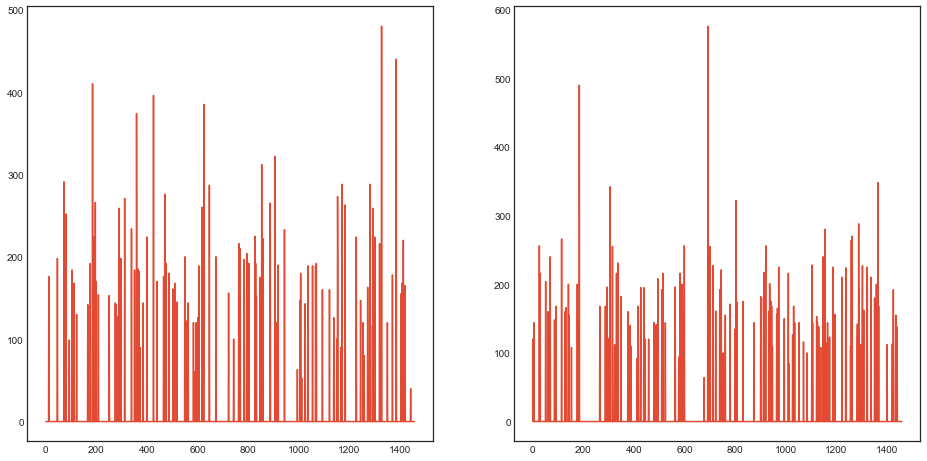

In [161]:
play_data.OpenPorchSF.sum()
plt.subplot(121)
plt.plot(play_data['ScreenPorch'])

plt.subplot(122)
test_data.OpenPorchSF.sum()
plt.plot(test_data['ScreenPorch'])

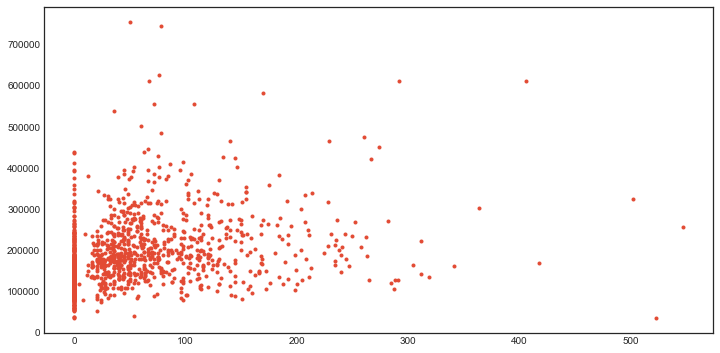

In [166]:
plt.figure(figsize=[12,6])
plt.plot(play_data['OpenPorchSF'], play_data.SalePrice,
         '.', alpha = 1)